In [23]:
# Import Libraries 
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

In [22]:
# Import Dataset 
import kagglehub 

path = kagglehub.dataset_download("adarshsng/lending-club-loan-data-csv")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\giamb\.cache\kagglehub\datasets\adarshsng\lending-club-loan-data-csv\versions\1


In [15]:
# List files in the directory to find the correct file name
files = os.listdir(path)
print("Files in directory:", files)

# Assuming the correct file is the first CSV file in the directory
csv_file = os.path.join(path, [file for file in files if file.endswith('.csv')][0])

# Load data into a pandas DataFrame
df = pd.read_csv(csv_file)

# Display the first few rows
df.head()

Files in directory: ['LCDataDictionary.xlsx', 'loan.csv']


C:\Users\giamb\AppData\Local\Temp\ipykernel_2684\1057770976.py:9: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# data cleaning 
missing_counts = df.isnull().sum()
print(missing_counts)

df = df.drop(columns=["id", "member_id"])
threshold = 0.5  # Drop columns with more than 50% missing values
df = df.dropna(thresh=len(df) * (1 - threshold), axis=1)

# Fill missing numerical values with the median
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing categorical values with the most common value (mode)
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")


id                       2260668
member_id                2260668
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
                          ...   
settlement_status        2227612
settlement_date          2227612
settlement_amount        2227612
settlement_percentage    2227612
settlement_term          2227612
Length: 145, dtype: int64
Total duplicate rows: 0


In [17]:
# REDEFINE THE TARGET VARIABLE FOR EASIER INTERPRETATION
# Define the mapping
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 1,
    'In Grace Period': 1,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 0,
    'Charged Off': 0,
    'Default': 0
}

# Apply the mapping to the 'Loan_Status' column
df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)
df.drop('loan_status', axis=1, inplace=True)

df['loan_status_binary'].value_counts()


C:\Users\giamb\AppData\Local\Temp\ipykernel_2684\2543088587.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)


loan_status_binary
1.0    1970599
0.0     287320
Name: count, dtype: int64

In [18]:
# TRANSFROM "OBJECT" COLUMNS INTO CATEGORICAL VARIABLES
# Remove leading/trailing whitespaces from object columns
df = df.apply(lambda col: col.str.strip() if col.dtypes == 'object' else col)

# Convert date columns to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%Y', errors='coerce')

# Convert percentage columns to numeric
df['int_rate'] = df['int_rate'].astype(str)
df['int_rate%'] = pd.to_numeric(df['int_rate'].str.replace('%', '', regex=False), errors='coerce')
df['revol_util'] = df['revol_util'].astype(str)
df['revol_util%'] = pd.to_numeric(df['revol_util'].str.replace('%', '', regex=False), errors='coerce')

# Drop unnecessary columns
columns_to_drop = {'title', 'zip_code', 'pymnt_plan', 'emp_title', 'int_rate', 'revol_util'}
df.drop(columns_to_drop, axis=1, inplace=True)

# Convert categorical flags to binary
df['debt_settlement_flag'] = np.where(df['debt_settlement_flag'] == 'Y', 1, 0)

# Convert term to binary
df['term_36_months'] = np.where(df['term'] == '36 months', 1, 0)
df.drop('term', axis=1, inplace=True)

# Convert emp_length to numeric
df['emp_length'] = df['emp_length'].replace({'< 1': '0', '10+': '10'}, regex=True)
df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')

# Fix hardship_flag handling
df['hardship_flag'] = df['hardship_flag'].fillna('N')

C:\Users\giamb\AppData\Local\Temp\ipykernel_2684\1460672302.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')


In [19]:
df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days
df['days_since_last_payment'] = (pd.Timestamp('today') - df['last_pymnt_d']).dt.days

Hot encoding for remaining categorical variables (Think whether to include it or not)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['grade', 'sub_grade', 'home_ownership', 'purpose', 'addr_state']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

EXPLORATORY DATA ANALYSIS 

<Axes: >

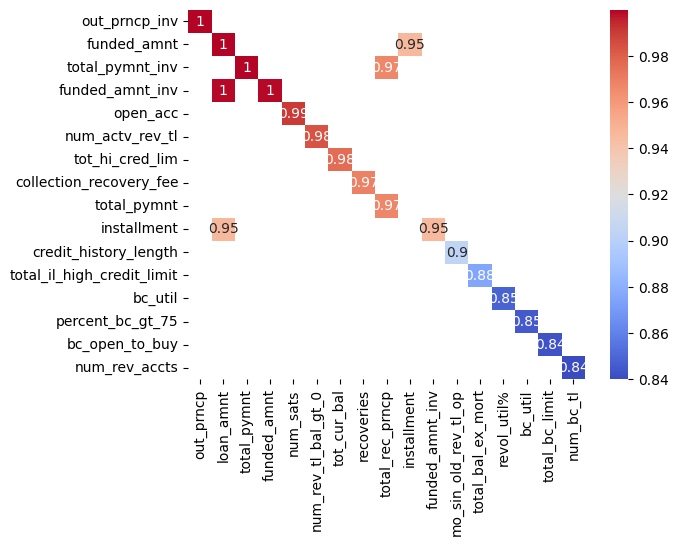

In [20]:
# top 20 correlations
corr = df.select_dtypes(include=['number']).corr()
corr = abs(corr)
for i in range(corr.shape[0]):
    corr.iloc[i,i] = 0
corr = corr.unstack().sort_values(ascending=False).drop_duplicates()
corr = corr[corr<1][:20].unstack(level=0)
corr
sns.heatmap(corr, annot=True, cmap='coolwarm')

Look at the most skewed variables, then apply log transfromation only to those

MODEL: LOGISTIC REGRESSION

What to improve below: 
- Identify the most skewed features throguh EDA 
- Pipeline use -> unify the three, also is there a need to use logistic regression for it

In [24]:
# Example: Identify skewed numerical features (this should be done via EDA)
skewed_features = ['loan_amnt', 'annual_inc']  # adjust based on your analysis

# Function for winsorization (example using np.clip)
def winsorize(X, lower_percentile=0.05, upper_percentile=0.95):
    X = np.array(X, dtype=float)
    lower = np.percentile(X, lower_percentile * 100)
    upper = np.percentile(X, upper_percentile * 100)
    return np.clip(X, lower, upper)

winsorizer = FunctionTransformer(winsorize, validate=False)
log_transformer = FunctionTransformer(np.log1p, validate=False)

# Preprocessor for numerical features: Apply log transform then winsorization then scaling
num_pipeline = Pipeline(steps=[
    ('log_transform', log_transformer),  # Only apply if the feature is skewed
    ('winsorize', winsorizer),
    ('scaler', StandardScaler())
])

# For categorical features: one-hot encode (list your categorical features)
categorical_features = ['grade', 'home_ownership', 'purpose']
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a ColumnTransformer: Apply the numerical pipeline only on the features you need
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, skewed_features),
    ('cat', cat_pipeline, categorical_features)
    # You can add more transformers for other features as needed.
], remainder='passthrough')  # keeps the rest of the features unchanged

# Split data after shuffling
df_shuffled = df.sample(frac=1, random_state=42)
X = df_shuffled.drop('loan_status_binary', axis=1)
y = df_shuffled['loan_status_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the pipeline with SMOTE for class balancing and Logistic Regression
pipeline_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])

# Fit the model
pipeline_lr.fit(X_train, y_train)

# Evaluate the model
print("Logistic Regression accuracy:", pipeline_lr.score(X_test, y_test))

KeyboardInterrupt: 

Using SHAP (or could use LIME) to interpret the most influential variables in the approval/decline decision

In [ ]:
import shap

# For tree-based models (e.g., XGBoost or Random Forest), SHAP is very efficient:
# Assuming 'model' is your fitted tree model:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Create a summary plot to see feature importance
shap.summary_plot(shap_values, X_test)
